In [514]:
from scipy.io import loadmat
from matplotlib.pyplot import (
    figure,
    subplot,
    plot,
    xlabel,
    ylabel,
    title,
    yticks,
    show,
    legend,
    imshow,
    cm,
)
import scipy.linalg as linalg
from scipy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import xlrd
import pandas as pd
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

file_path = r"C:\Users\Admin\Documents\GitHub\Machine-Learning-report1\MAIN_Movies_DS.xls"
doc = xlrd.open_workbook(file_path).sheet_by_index(0)

# Extract attribute names
attributeNames = doc.row_values(0, 2, 10)

# Extract MPAA names to python list, then encode with integers (dict)
mpaa = doc.col_values(3, 2, 636)
mpaa_name = sorted(set(mpaa))  # set because it deletes the duplicates
mpaaDict = dict(zip(mpaa_name, range(5)))

# Extract names to python list, then encode with integers (dict)
# the column Genre was moved to this position in excel
genre = doc.col_values(2, 2, 636)
genre_name = sorted(set(genre))
genreDict = dict(zip(genre_name, range(18)))
print(genreDict)

title = doc.col_values(1, 2, 636)
title_name = sorted(set(title))
titleDict = dict(zip(title_name, range(627)))

rating = doc.col_values(8, 2, 636)
rating_name = sorted(set(rating))
ratDict = dict(zip(rating_name, range(627)))

# Extract vector y, convert to NumPy array
y_mpaa = np.array([mpaaDict[value] for value in mpaa])
y_genre = np.array([genreDict[value] for value in genre])
y_title = np.array([titleDict[value] for value in title])
y_rat = np.array([ratDict[value] for value in rating])

{'Action': 0, 'Adventure': 1, 'Animation': 2, 'Comedy': 3, 'Crime': 4, 'Drama': 5, 'Family': 6, 'Fantasy': 7, 'History': 8, 'Horror': 9, 'Musical': 10, 'Mystery': 11, 'Romance': 12, 'Science Fiction': 13, 'Thriller': 14, 'War': 15, 'Western': 16}


### Main dataframe to use for regression and classification

In [515]:
# Create a dataframe from the data
data = pd.DataFrame(
    {
        "MPAA_Rating": y_mpaa,
        "genre": y_genre,
        "title": y_title,
        "Budget": doc.col_values(4, 2, 636),
        "Gross": doc.col_values(5, 2, 636),
        "release_date": doc.col_values(6, 2, 636),
        "runtime": doc.col_values(7, 2, 636),
        "rating": doc.col_values(8, 2, 636),
        "rating_count": doc.col_values(9, 2, 636),
    }
)

# DATA CLEANING
# Remove duplicates based on the "title" column
data = data.drop_duplicates(subset="title", keep="first")

# Extract X and y from the cleaned dataframe
X = data[
    [
        "MPAA_Rating",
        "genre",
        "Budget",
        "Gross",
        "release_date",
        "runtime",
        "rating",
        "rating_count",
    ]
].values
y_mpaa = data["MPAA_Rating"].values
y_genre = data["genre"].values
y_gross = data["Gross"].values > 4 * data["Budget"].values
y_rat = data["rating"].values > 7

N_mpaa = len(y_mpaa)
N_genre = len(y_genre)
M = len(attributeNames)
C_mpaa = len(mpaa_name)
C_genre = len(genre_name)

df_X = pd.DataFrame(X, columns=[
        "MPAA_Rating",
        "genre",
        "Budget",
        "Gross",
        "release_date",
        "runtime",
        "rating",
        "rating_count",
    ])
print(df_X)

     MPAA_Rating  genre       Budget        Gross  release_date  runtime  \
0            1.0    3.0    7500000.0  145793296.0       32855.0     99.0   
1            1.0    4.0   13000000.0   71079915.0       32717.0    100.0   
2            3.0   15.0   14000000.0  161001698.0       32862.0    145.0   
3            1.0    5.0   15000000.0   84431625.0       32619.0    107.0   
4            1.0    6.0   15000000.0   79258538.0       32736.0    100.0   
..           ...    ...          ...          ...           ...      ...   
621          2.0    0.0  250000000.0  765199095.0       44477.0    163.0   
622          2.0   10.0   55000000.0     106457.0       44512.0    115.0   
623          2.0    0.0  110000000.0  212500000.0       44470.0    157.0   
624          2.0    3.0   17000000.0  115400000.0       41187.0    112.0   
625          2.0    3.0   20000000.0   57200000.0       38793.0    105.0   

     rating  rating_count  
0       7.4       91075.0  
1       7.2       91415.0  
2  

In [516]:
'''# Creating dictionaries
genreNames = [gen for gen in genreDict]
mpaaNames = [mpa for mpa in mpaaDict]
ratingNames = [rat for rat in ratDict]

# Select subset of digits classes to be inspected
class_mask = np.zeros(N_mpaa).astype(bool)

# Selection of the genree to visualize
# genres = range(18)
genres = [0, 2, 9, 15]
# mpaas = [1, 3]
# gross = [0, 1]
# ratings = [0, 1, 2, 3]
for v in genres:
    cmsk = y_genre == v
    class_mask = class_mask | cmsk

X = X[class_mask, :]
y_genre = y_genre[class_mask]
N = X.shape[0]'''

'# Creating dictionaries\ngenreNames = [gen for gen in genreDict]\nmpaaNames = [mpa for mpa in mpaaDict]\nratingNames = [rat for rat in ratDict]\n\n# Select subset of digits classes to be inspected\nclass_mask = np.zeros(N_mpaa).astype(bool)\n\n# Selection of the genree to visualize\n# genres = range(18)\ngenres = [0, 2, 9, 15]\n# mpaas = [1, 3]\n# gross = [0, 1]\n# ratings = [0, 1, 2, 3]\nfor v in genres:\n    cmsk = y_genre == v\n    class_mask = class_mask | cmsk\n\nX = X[class_mask, :]\ny_genre = y_genre[class_mask]\nN = X.shape[0]'

### Estimation of Lambda with 10 fold CV

[0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24602150537634393, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.24279569892473118, 0.2427956989

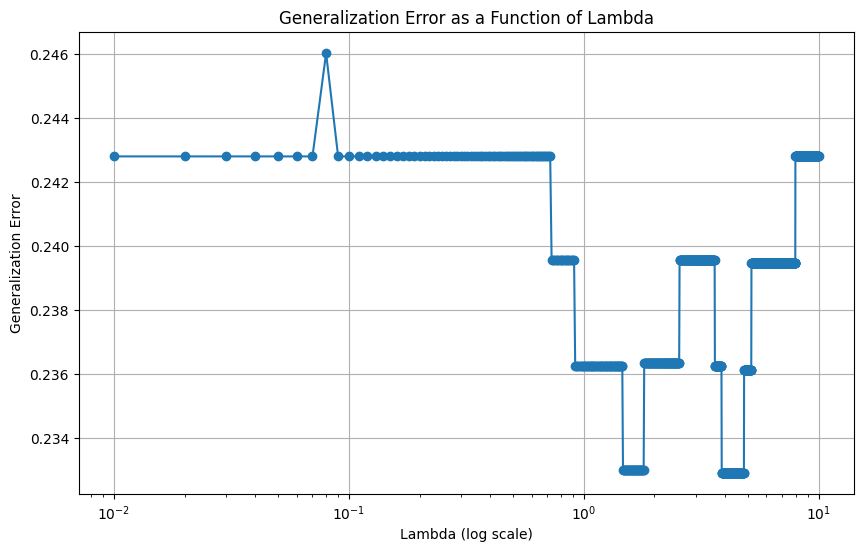

In [549]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# y_mpaa = vector with MPAA ratings of the movies
# y_mpaa_filtered = y_mpaa with only PG e R 
# df_X = features matrix (panda dataframe)
# df_X_filtered = df_X with only movies that are PG or R
# df_X_noMPAA = df_X_filtered without mpaa column
# df_X_noMPAA_std = df_X_noMPAA standardised

# keep in X only the movies that have PG or R rating
y_mpaa = df_X['MPAA_Rating']
print
df_X_filtered = df_X[(df_X['MPAA_Rating'] != 0) & (df_X['MPAA_Rating'] != 2)]
y_mpaa_filtered = df_X_filtered["MPAA_Rating"]

# remove the mpaa_rating column from X
df_X_noMPAA = df_X_filtered.drop(columns=['MPAA_Rating'])

# Standardization
scaler = StandardScaler()
scaler.fit(df_X_noMPAA)
df_X_noMPAA_std = scaler.transform(df_X_noMPAA)

# Define the range of λ values to explore
lambda_values = [0.01, 0.02, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 200, 1000]
lambda_values_2it = np.arange(0.01, 10.01, 0.01, dtype = "float")
#lambda_values = np.arange(0.02, 10, 0.2, dtype="float")

#errors contains generalization error for each lambda
errors = []
best_error = 1
best_lambda = None

for lambda_i in lambda_values_2it:
    model = LogisticRegression(C = 1/lambda_i)

    #10 fold cross validation 
    scores = cross_val_score(model, df_X_noMPAA_std, y_mpaa_filtered, cv=10)
    mean_score = scores.mean()

    #generalization error for lambda_i
    gen_err = 1 - mean_score
    errors.append(gen_err)
    if gen_err < best_error:
        best_error = gen_err #update the lowest generalization error
        best_lambda = lambda_i #update the best lambda

print(errors)
print(f"best error = {best_error}, best lambda = {best_lambda}")

# Create a plot of generalization error as a function of λ
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values_2it, errors, marker='o', linestyle='-')
plt.title('Generalization Error as a Function of Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Generalization Error')
plt.grid(True)
plt.show()
          


### Logistic regression with 2 level CV (10 outer folds and 10 inner folds)

[0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.24841269841269842, 0.25211640211640207, 0.25582010582010584, 0.2521164021164022, 0.25582010582010584, 0.2595238095238096, 0.2595238095238096, 0.2706349206349207, 0.2780423280423281, 0.37129629629629635]
best error = 0.24841269841269842, best lambda = 0.01


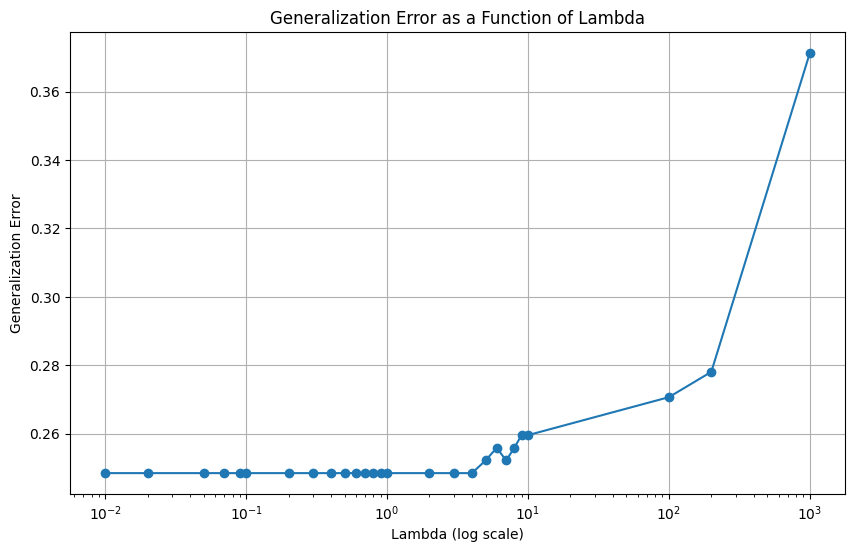

[0.24510582010582005, 0.24510582010582005, 0.24510582010582005, 0.24510582010582005, 0.24510582010582005, 0.24510582010582005, 0.2414021164021165, 0.2414021164021165, 0.2414021164021165, 0.2414021164021165, 0.23769841269841263, 0.23769841269841263, 0.23769841269841263, 0.23769841269841263, 0.23769841269841263, 0.23756613756613754, 0.23756613756613754, 0.2412698412698413, 0.24497354497354507, 0.24867724867724872, 0.2414021164021165, 0.2414021164021165, 0.24510582010582016, 0.24510582010582016, 0.2929894179894179, 0.2932539682539682, 0.400925925925926]
best error = 0.23756613756613754, best lambda = 2


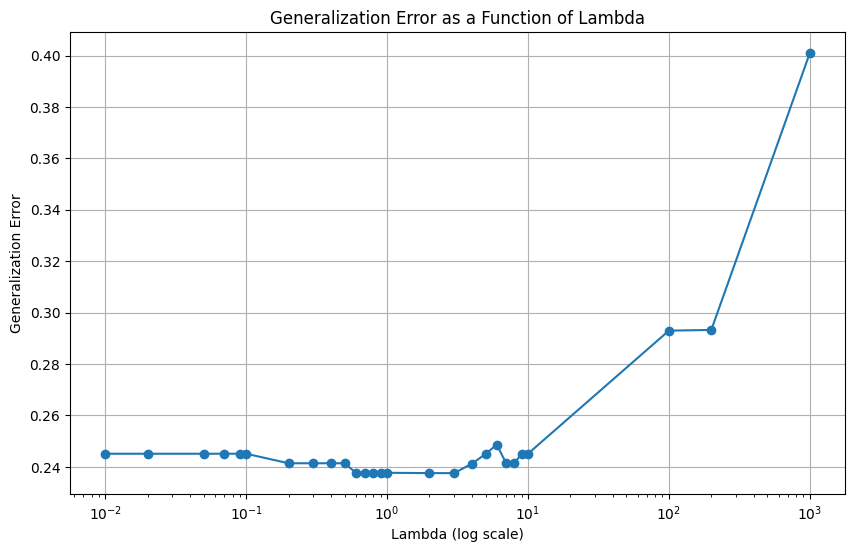

[0.24497354497354495, 0.24497354497354495, 0.24497354497354495, 0.24497354497354495, 0.24497354497354495, 0.24497354497354495, 0.24497354497354495, 0.24497354497354495, 0.24497354497354495, 0.24867724867724872, 0.24867724867724872, 0.24867724867724872, 0.24867724867724872, 0.24867724867724872, 0.24867724867724872, 0.24867724867724872, 0.25224867724867717, 0.25224867724867717, 0.2522486772486774, 0.2522486772486774, 0.2522486772486774, 0.2522486772486773, 0.2523809523809524, 0.2596560846560847, 0.2744708994708994, 0.2932539682539682, 0.40449735449735447]
best error = 0.24497354497354495, best lambda = 0.01


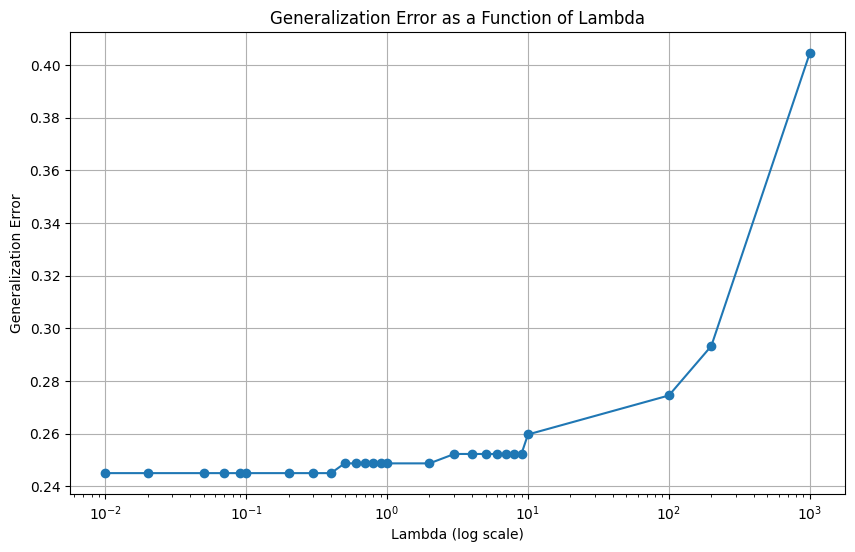

[0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.21111111111111103, 0.2146825396825397, 0.2146825396825397, 0.21111111111111103, 0.21111111111111103, 0.22923280423280423, 0.23664021164021154, 0.23293650793650789, 0.2402116402116402, 0.24761904761904763, 0.24761904761904763, 0.24761904761904763, 0.24761904761904763, 0.24761904761904763, 0.2584656084656085, 0.29193121693121693, 0.34457671957671954]
best error = 0.21111111111111103, best lambda = 0.01


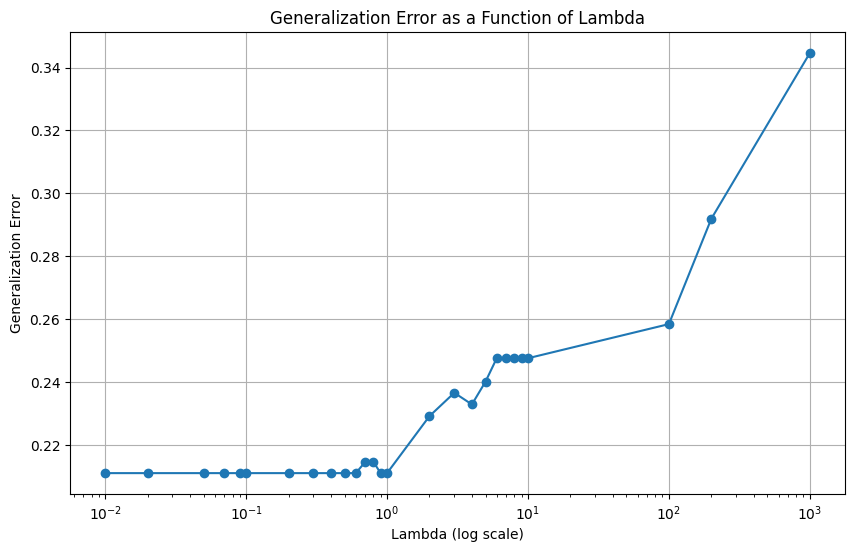

[0.2404761904761904, 0.2404761904761904, 0.2404761904761904, 0.2404761904761904, 0.2404761904761904, 0.2404761904761904, 0.2404761904761904, 0.24417989417989416, 0.24417989417989416, 0.24417989417989416, 0.24417989417989416, 0.24417989417989416, 0.24417989417989416, 0.2404761904761904, 0.2404761904761904, 0.2332010582010582, 0.23677248677248675, 0.2332010582010582, 0.24404761904761896, 0.24404761904761896, 0.24761904761904763, 0.25489417989417995, 0.25489417989417995, 0.2511904761904763, 0.2768518518518519, 0.2953703703703704, 0.3555555555555555]
best error = 0.2332010582010582, best lambda = 2


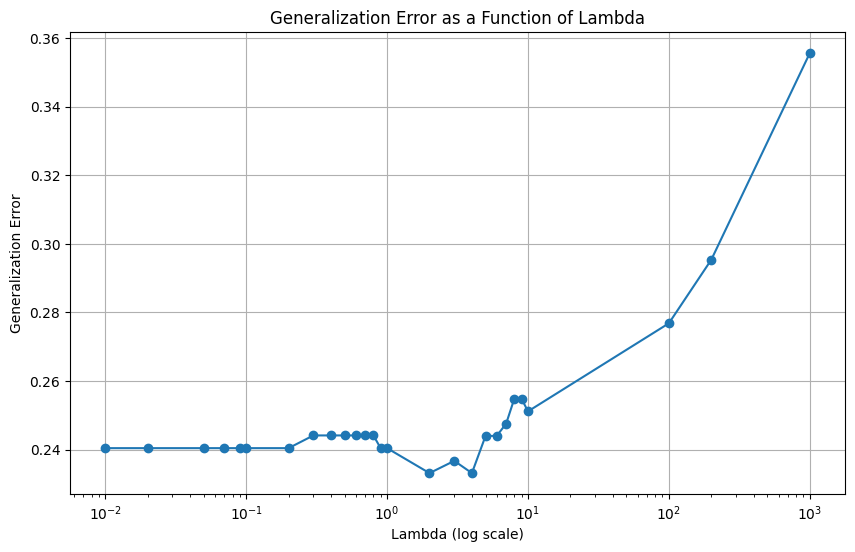

[0.2399470899470899, 0.2399470899470899, 0.2399470899470899, 0.2399470899470899, 0.2399470899470899, 0.2399470899470899, 0.2399470899470899, 0.2399470899470899, 0.24365079365079356, 0.24365079365079356, 0.2399470899470899, 0.2399470899470899, 0.23637566137566135, 0.2326719576719578, 0.2326719576719578, 0.2326719576719578, 0.2326719576719578, 0.23624338624338626, 0.23981481481481493, 0.24351851851851847, 0.24351851851851847, 0.2507936507936508, 0.25436507936507935, 0.2580687830687831, 0.261904761904762, 0.28783068783068777, 0.34417989417989425]
best error = 0.2326719576719578, best lambda = 0.9


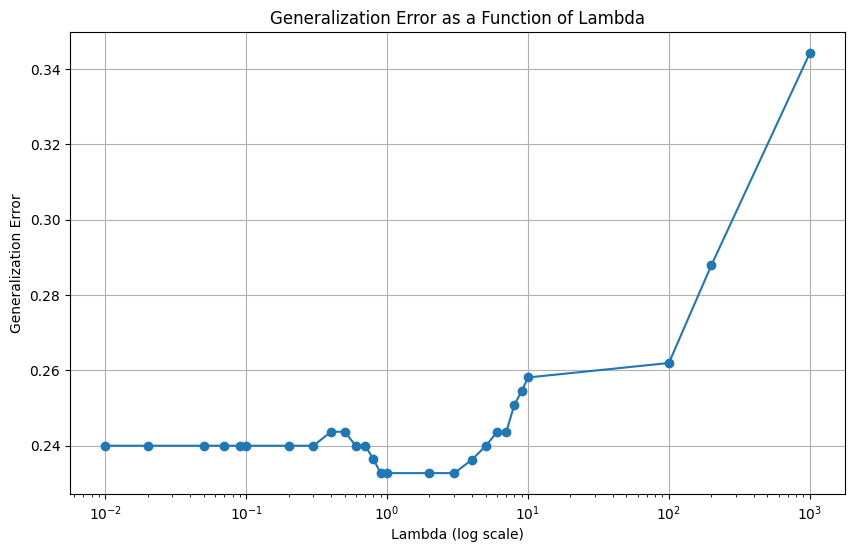

[0.22962962962962963, 0.22962962962962963, 0.22962962962962963, 0.22962962962962963, 0.22962962962962963, 0.22962962962962963, 0.22605820105820096, 0.22592592592592597, 0.22592592592592597, 0.22592592592592597, 0.22962962962962963, 0.22962962962962963, 0.22962962962962963, 0.22962962962962963, 0.22962962962962963, 0.22592592592592597, 0.22579365079365077, 0.22579365079365077, 0.22579365079365077, 0.22579365079365077, 0.22208994708994712, 0.22579365079365077, 0.22579365079365077, 0.22579365079365077, 0.25489417989417995, 0.26243386243386246, 0.2849206349206349]
best error = 0.22208994708994712, best lambda = 7


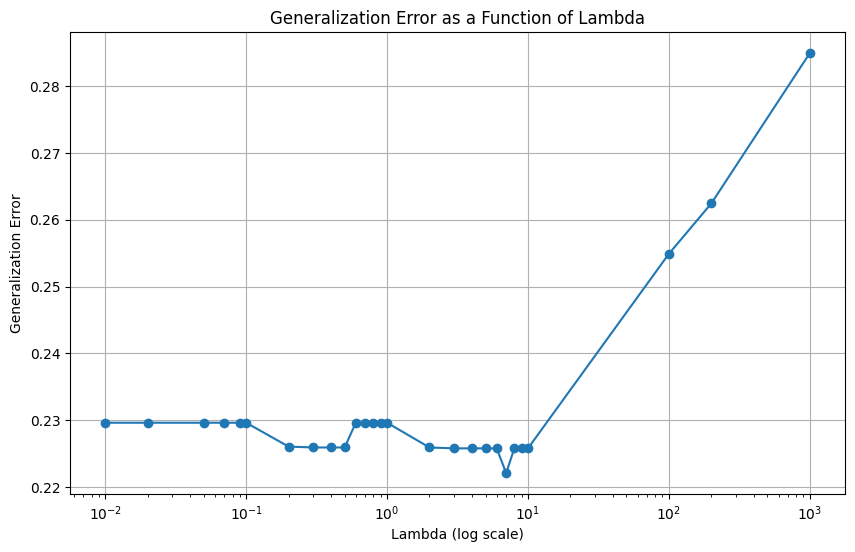

[0.24365079365079367, 0.24365079365079367, 0.24365079365079367, 0.24365079365079367, 0.2399470899470899, 0.2399470899470899, 0.23637566137566135, 0.23637566137566135, 0.2399470899470899, 0.2399470899470899, 0.2399470899470899, 0.23637566137566135, 0.240079365079365, 0.23650793650793633, 0.23650793650793633, 0.22910052910052914, 0.23624338624338626, 0.23624338624338626, 0.23624338624338626, 0.24735449735449744, 0.24735449735449744, 0.24735449735449744, 0.24735449735449744, 0.24378306878306888, 0.2768518518518519, 0.2952380952380953, 0.3667989417989418]
best error = 0.22910052910052914, best lambda = 2


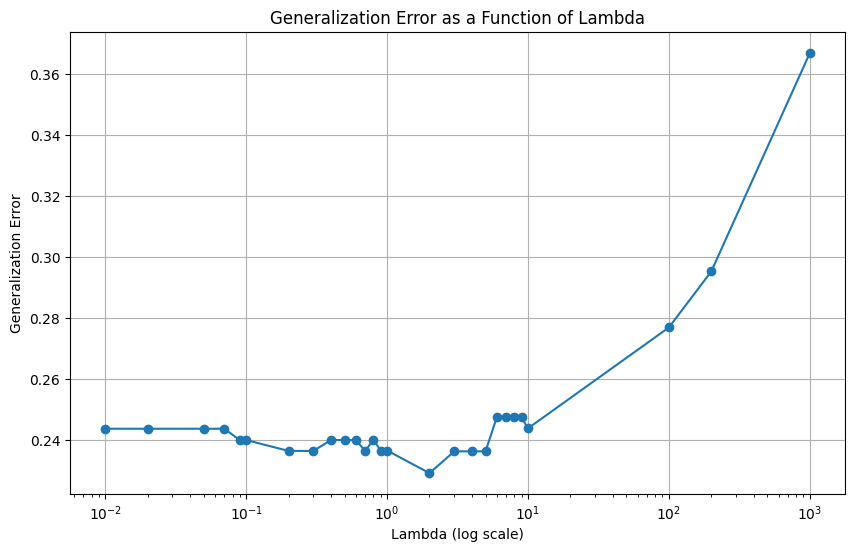

[0.23611111111111105, 0.23611111111111105, 0.23611111111111105, 0.2325396825396826, 0.2325396825396826, 0.2325396825396826, 0.22896825396825393, 0.22896825396825393, 0.22896825396825393, 0.22896825396825393, 0.22896825396825393, 0.22526455026455028, 0.22156084656084662, 0.22156084656084662, 0.22156084656084662, 0.21812169312169316, 0.22526455026455028, 0.22526455026455028, 0.22896825396825393, 0.22539682539682537, 0.22896825396825393, 0.23611111111111116, 0.23968253968253972, 0.23968253968253972, 0.26216931216931205, 0.2767195767195767, 0.36335978835978844]
best error = 0.21812169312169316, best lambda = 2


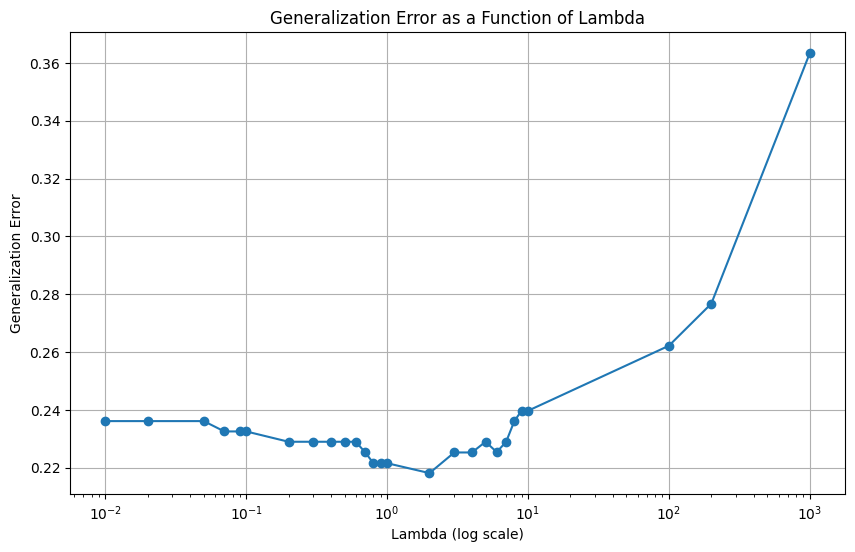

[0.24060846560846572, 0.24060846560846572, 0.24060846560846572, 0.24060846560846572, 0.24060846560846572, 0.24060846560846572, 0.24060846560846572, 0.24060846560846572, 0.24060846560846572, 0.24431216931216926, 0.24431216931216926, 0.23703703703703705, 0.23703703703703705, 0.23703703703703705, 0.23703703703703705, 0.23690476190476184, 0.2404761904761905, 0.24417989417989416, 0.24417989417989416, 0.24404761904761896, 0.24775132275132283, 0.24404761904761918, 0.24404761904761918, 0.24761904761904763, 0.2884920634920636, 0.30687830687830686, 0.39947089947089953]
best error = 0.23690476190476184, best lambda = 2


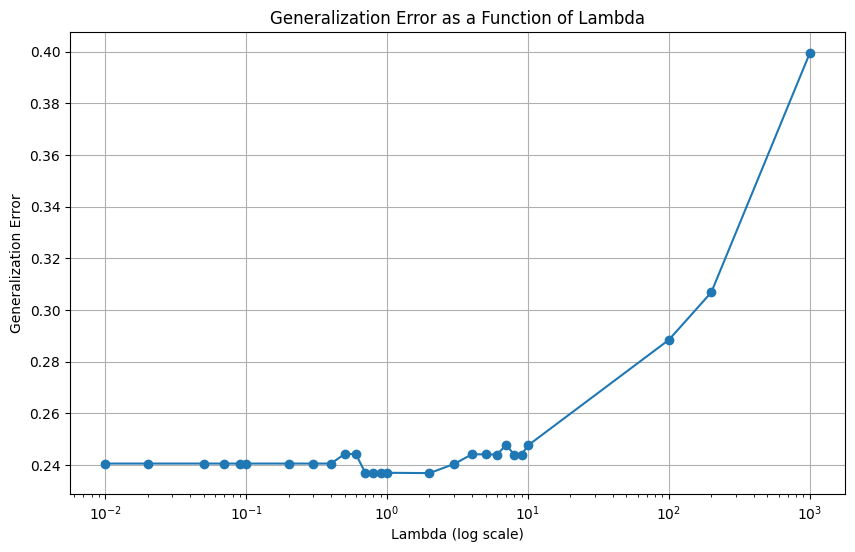

In [570]:

# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

# Perform outer cross-validation
for train_index, test_index in outer_cv.split(df_X_noMPAA_std):
    X_train = df_X_noMPAA_std[train_index]
    y_train = y_mpaa_filtered.to_numpy()[train_index]

    # Define the range of λ values to explore
    lambda_values = [0.01, 0.02, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 200, 1000]
    lambda_values_2it = np.arange(0.01, 10.01, 0.01, dtype = "float")
    #lambda_values = np.arange(0.02, 10, 0.2, dtype="float")

    #errors contains generalization error for each lambda
    errors = []
    best_error_lambda_i = 1
    best_lambda_i = None

    for lambda_i in lambda_values:
        inner_model = LogisticRegression(C = 1/lambda_i)

        #10 fold cross validation 
        scores = cross_val_score(inner_model, X_train, y_train, cv=10)
        mean_score = scores.mean()

        #generalization error for lambda_i
        gen_err_lambda_i = 1 - mean_score
        errors.append(gen_err_lambda_i)
        if gen_err_lambda_i < best_error_lambda_i:
            best_error_lambda_i = gen_err_lambda_i #update the lowest generalization error
            best_lambda_i = lambda_i #update the best lambda

    print(errors)
    print(f"best error = {best_error_lambda_i}, best lambda = {best_lambda_i}")
    # Create a plot of generalization error as a function of λ
    plt.figure(figsize=(10, 6))
    plt.semilogx(lambda_values, errors, marker='o', linestyle='-')
    plt.title('Generalization Error as a Function of Lambda')
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Generalization Error')
    plt.grid(True)
    plt.show()
          
        


### Logistic regression with 2 level CV: First iteration for Lambda


Fold 1 Optimal λ value: 0.01
Fold 2 Optimal λ value: 0.4
Fold 3 Optimal λ value: 0.01
Fold 4 Optimal λ value: 0.01
Fold 5 Optimal λ value: 0.01
Fold 6 Optimal λ value: 0.01
Fold 7 Optimal λ value: 0.6
Fold 8 Optimal λ value: 1
Fold 9 Optimal λ value: 0.01
Fold 10 Optimal λ value: 0.06
Fold 1 Error: 0.22580645161290325
Fold 2 Error: 0.29032258064516125
Fold 3 Error: 0.16129032258064513
Fold 4 Error: 0.30000000000000004
Fold 5 Error: 0.16666666666666663
Fold 6 Error: 0.2666666666666667
Fold 7 Error: 0.16666666666666663
Fold 8 Error: 0.23333333333333328
Fold 9 Error: 0.2666666666666667
Fold 10 Error: 0.19999999999999996
Mean Error: 0.22774193548387095
Best Lambda: 0.01


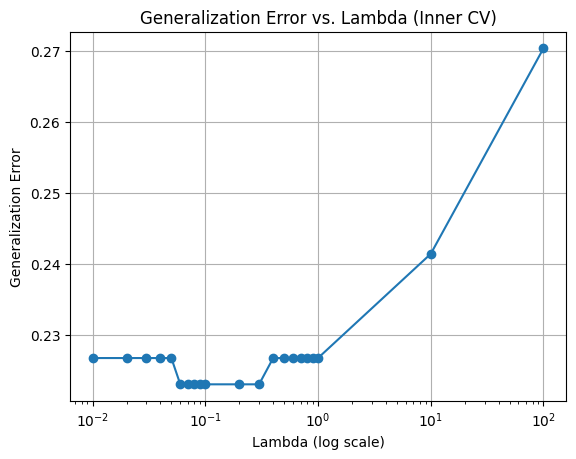

In [520]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# y_mpaa = vector with MPAA ratings of the movies
# y_mpaa_filtered = y_mpaa with only PG e R 
# df_X = features matrix (panda dataframe)
# df_X_filtered = df_X with only movies that are PG or R
# df_X_noMPAA = df_X_filtered without mpaa column
# df_X_noMPAA_std = df_X_noMPAA standardised

# keep in X only the movies that have PG or R rating
y_mpaa = df_X['MPAA_Rating']
df_X_filtered = df_X[(df_X['MPAA_Rating'] != 0) & (df_X['MPAA_Rating'] != 2)]
y_mpaa_filtered = df_X_filtered["MPAA_Rating"]

# remove the mpaa_rating column from X
df_X_noMPAA = df_X_filtered.drop(columns=['MPAA_Rating'])

# Standardization
scaler = StandardScaler()
scaler.fit(df_X_noMPAA)
df_X_noMPAA_std = scaler.transform(df_X_noMPAA)

# Define the range of λ values to explore
lambda_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100]

# Initialize a list for generalization error results
errors = []

# Initialize a variable for the best lambda value
best_lambda = None
best_error = float('inf')

# Perform 2-level cross-validation
outer_kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(outer_kfold.split(df_X_noMPAA_std)):
    # Split the data into training and testing sets for the outer fold
    X_train_outer, X_test_outer = df_X_noMPAA_std[train_idx], df_X_noMPAA_std[test_idx]
    y_train_outer, y_test_outer = y_mpaa_filtered.iloc[train_idx], y_mpaa_filtered.iloc[test_idx]

    # Initialize a list for inner fold errors
    inner_errors = []

    for lambda_val in lambda_values:
        model = LogisticRegression(C=1/lambda_val, solver='lbfgs', max_iter=10000)  # We use C instead of λ
        inner_kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold cross-validation for the inner loop
        cv_scores = cross_val_score(model, X_train_outer, y_train_outer, cv=inner_kfold, scoring='accuracy')
        mean_error = 1 - np.mean(cv_scores)  # Generalization error
        inner_errors.append(mean_error)

    # Find the optimal λ value that minimizes the error for this outer fold
    optimal_lambda = lambda_values[np.argmin(inner_errors)]

    # Train a model with the optimal λ value on the entire training set for this outer fold
    model = LogisticRegression(C=1/optimal_lambda, solver='lbfgs', max_iter=10000)
    model.fit(X_train_outer, y_train_outer)

    # Evaluate the model on the test set for this outer fold
    y_pred = model.predict(X_test_outer)
    outer_error = 1 - (y_pred == y_test_outer).mean()
    errors.append(outer_error)

    # Update the best lambda if this fold had a lower error
    if outer_error < best_error:
        best_error = outer_error
        best_lambda = optimal_lambda

    # Print the optimal λ value for this fold
    print(f"Fold {i+1} Optimal λ value: {optimal_lambda}")

# Print the errors for each fold
for i, error in enumerate(errors):
    print(f"Fold {i+1} Error: {error}")

# Calculate the mean error across all outer folds
mean_error = np.mean(errors)

# Print the mean error and the best lambda
print(f"Mean Error: {mean_error}")
print(f"Best Lambda: {best_lambda}")

# Create a plot to visualize the generalization error
plt.figure()
plt.semilogx(lambda_values, inner_errors, marker='o')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Generalization Error')
plt.title('Generalization Error vs. Lambda (Inner CV)')
plt.grid(True)
plt.show()


### Second iteration for Lambda

Fold 1 Optimal λ value: 0.01
Fold 2 Optimal λ value: 0.4
Fold 3 Optimal λ value: 0.25
Fold 4 Optimal λ value: 0.01
Fold 5 Optimal λ value: 0.01
Fold 6 Optimal λ value: 0.01
Fold 7 Optimal λ value: 0.01
Fold 8 Optimal λ value: 10
Fold 9 Optimal λ value: 0.01
Fold 10 Optimal λ value: 0.1
Fold 1 Error: 0.22580645161290325
Fold 2 Error: 0.29032258064516125
Fold 3 Error: 0.16129032258064513
Fold 4 Error: 0.30000000000000004
Fold 5 Error: 0.16666666666666663
Fold 6 Error: 0.2666666666666667
Fold 7 Error: 0.16666666666666663
Fold 8 Error: 0.23333333333333328
Fold 9 Error: 0.2666666666666667
Fold 10 Error: 0.19999999999999996
Mean Error: 0.22774193548387095
Best Lambda: 0.25


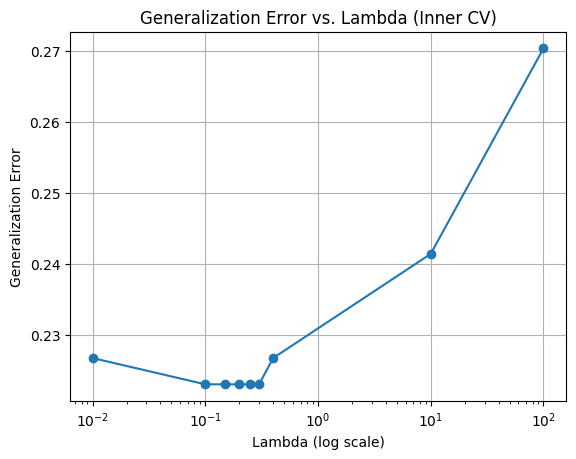

In [521]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# y_mpaa = vector with MPAA ratings of the movies
# y_mpaa_filtered = y_mpaa with only PG e R 
# df_X = features matrix (panda dataframe)
# df_X_filtered = df_X with only movies that are PG or R
# df_X_noMPAA = df_X_filtered without mpaa column
# df_X_noMPAA_std = df_X_noMPAA standardised

# keep in X only the movies that have PG or R rating
y_mpaa = df_X['MPAA_Rating']
df_X_filtered = df_X[(df_X['MPAA_Rating'] != 0) & (df_X['MPAA_Rating'] != 2)]
y_mpaa_filtered = df_X_filtered["MPAA_Rating"]

# remove the mpaa_rating column from X
df_X_noMPAA = df_X_filtered.drop(columns=['MPAA_Rating'])

# Standardization
scaler = StandardScaler()
scaler.fit(df_X_noMPAA)
df_X_noMPAA_std = scaler.transform(df_X_noMPAA)

# Define the range of λ values to explore
lambda_values = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 10, 100]

# Initialize a list for generalization error results
errors = []

# Initialize a variable for the best lambda value
best_lambda = None
best_error = float('inf')

# Perform 2-level cross-validation
outer_kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(outer_kfold.split(df_X_noMPAA_std)):
    # Split the data into training and testing sets for the outer fold
    X_train_outer, X_test_outer = df_X_noMPAA_std[train_idx], df_X_noMPAA_std[test_idx]
    y_train_outer, y_test_outer = y_mpaa_filtered.iloc[train_idx], y_mpaa_filtered.iloc[test_idx]

    # Initialize a list for inner fold errors
    inner_errors = []

    for lambda_val in lambda_values:
        model = LogisticRegression(C=1/lambda_val, solver='lbfgs', max_iter=10000)  # We use C instead of λ
        inner_kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold cross-validation for the inner loop
        cv_scores = cross_val_score(model, X_train_outer, y_train_outer, cv=inner_kfold, scoring='accuracy')
        mean_error = 1 - np.mean(cv_scores)  # Generalization error
        inner_errors.append(mean_error)

    # Find the optimal λ value that minimizes the error for this outer fold
    optimal_lambda = lambda_values[np.argmin(inner_errors)]

    # Train a model with the optimal λ value on the entire training set for this outer fold
    model = LogisticRegression(C=1/optimal_lambda, solver='lbfgs', max_iter=10000)
    model.fit(X_train_outer, y_train_outer)

    # Evaluate the model on the test set for this outer fold
    y_pred = model.predict(X_test_outer)
    outer_error = 1 - (y_pred == y_test_outer).mean()
    errors.append(outer_error)

    # Update the best lambda if this fold had a lower error
    if outer_error < best_error:
        best_error = outer_error
        best_lambda = optimal_lambda

    # Print the optimal λ value for this fold
    print(f"Fold {i+1} Optimal λ value: {optimal_lambda}")

# Print the errors for each fold
for i, error in enumerate(errors):
    print(f"Fold {i+1} Error: {error}")

# Calculate the mean error across all outer folds
mean_error = np.mean(errors)

# Print the mean error and the best lambda
print(f"Mean Error: {mean_error}")
print(f"Best Lambda: {best_lambda}")

# Create a plot to visualize the generalization error
plt.figure()
plt.semilogx(lambda_values, inner_errors, marker='o')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Generalization Error')
plt.title('Generalization Error vs. Lambda (Inner CV)')
plt.grid(True)
plt.show()


Optimal λ value: 0.2


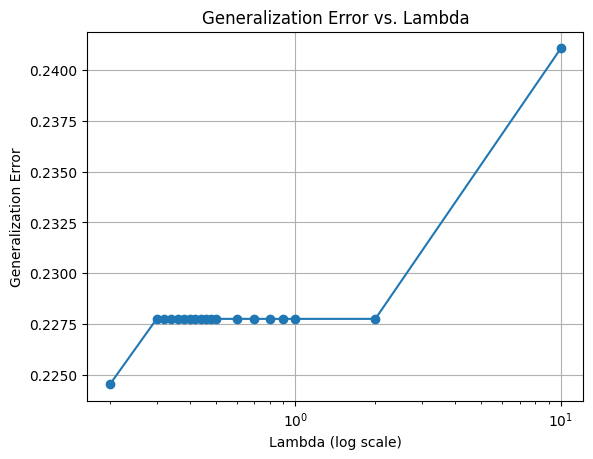

In [ ]:
#Define the range of λ values to explore
lambda_values = [0.2, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 10]

# Initialize a list for generalization error results
errors = []

# Perform cross-validation for each λ value
for lambda_val in lambda_values:
    model = LogisticRegression(C=1/lambda_val, solver='lbfgs', max_iter=10000)  # We use C instead of λ
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold cross-validation
    cv_scores = cross_val_score(model, df_X_noMPAA_std, y_mpaa_filtered, cv=kfold, scoring='accuracy')
    mean_error = 1 - np.mean(cv_scores)  # Generalization error
    errors.append(mean_error)

# Find the optimal λ value that minimizes the error
optimal_lambda = lambda_values[np.argmin(errors)]

# Print the optimal λ value
print(f"Optimal λ value: {optimal_lambda}")

# Create a plot to visualize the generalization error
plt.figure()
plt.semilogx(lambda_values, errors, marker='o')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Generalization Error')
plt.title('Generalization Error vs. Lambda')
plt.grid(True)
plt.show()


### Baseline without 2 level cross validation

In [ ]:
import pandas as pd
from sklearn.dummy import DummyClassifier

# y_mpaa = vector with MPAA ratings of the movies
# y_mpaa_filtered = y_mpaa with only PG and R
# df_X = features matrix (Pandas DataFrame)
# df_X_filtered = df_X with only movies that are PG or R
# df_X_noMPAA = df_X_filtered without the MPAA column
# df_X_noMPAA_std = standardized df_X_noMPAA

# number of MPAA Rating = 1
num_mpaa_1 = (y_mpaa_filtered == 1).sum()

# number of MPAA rating = 3
num_mpaa_3 = (y_mpaa_filtered == 3).sum()

print(f"film rated PG (1) = {num_mpaa_1} , film rated R (3) = {num_mpaa_3}")

# Calculate the most frequent MPAA Rating class in the training data
most_frequent_mpaa = y_mpaa_filtered.value_counts().idxmax()

# Create a dummy classifier based on the most frequent MPAA Rating class
baseline_model = DummyClassifier(strategy="constant", constant=int(most_frequent_mpaa))

# Train the baseline model
baseline_model.fit(df_X_noMPAA_std, y_mpaa_filtered)

# Calculate the performance of the baseline model on the training data
baseline_accuracy = baseline_model.score(df_X_noMPAA_std, y_mpaa_filtered)

# Now 'baseline_accuracy' will contain the performance of the baseline model
print("accuracy on training data = " , baseline_accuracy)


film rated PG (1) = 161 , film rated R (3) = 142
accuracy on training data =  0.5313531353135313


### Baseline with 2 level cross validation

In [ ]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold

# Initialize variables to store total misclassified observations and total test observations
total_misclassified = 0
total_test_observations = 0

# Create the outer loop for cross-validation (10-fold)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in outer_cv.split(df_X_noMPAA_std, y_mpaa_filtered):
    X_train, X_test = df_X_noMPAA_std.iloc[train_index], df_X_noMPAA_std.iloc[test_index]
    y_train, y_test = y_mpaa_filtered.iloc[train_index], y_mpaa_filtered.iloc[test_index]
    
    # Number of MPAA Rating = 1 in the test set
    num_mpaa_1_test = (y_test == 1).sum()
    
    # Number of MPAA Rating = 3 in the test set
    num_mpaa_3_test = (y_test == 3).sum()
    
    # Calculate the most frequent MPAA Rating class in the training data
    most_frequent_mpaa = y_train.value_counts().idxmax()

    # Create a dummy classifier based on the most frequent MPAA Rating class
    baseline_model = DummyClassifier(strategy="constant", constant=int(most_frequent_mpaa))

    # Train the baseline model on the training data
    baseline_model.fit(X_train, y_train)

    # Predict the MPAA Ratings on the test set
    y_pred = baseline_model.predict(X_test)

    # Calculate the number of misclassified observations in the test set
    misclassified = (y_test != y_pred).sum()

    # Increment the total misclassified and total test observations
    total_misclassified += misclassified
    total_test_observations += len(y_test)

# Calculate the error as (Number of misclassified observations) / (Total test observations)
error = total_misclassified / total_test_observations

# Now 'error' will contain the error rate across the 10 outer folds
print("Error rate = ", error)


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

### KNN